In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# notebook will reload external python modules
%load_ext autoreload
%autoreload 2

In [2]:
# import data
data_raw = pd.read_csv('./data/iris.data', header=None)
# only 2 classes are needed
data = np.array(data_raw)[:100]

In [3]:
all_num = data.shape[0]
val_num = all_num // 5
test_num = all_num // 5
train_num = all_num - val_num - test_num
print('all_num:{}, val_num:{}, test_num:{}, train_num:{}'.format(all_num, val_num, test_num, train_num))

all_num:100, val_num:20, test_num:20, train_num:60


In [4]:
# change the label into {-1, 1}
for idx in range(all_num):
    item = data[idx][4]
    if item == 'Iris-setosa':
        data[idx][4] = 0
    elif item == 'Iris-versicolor':
        data[idx][4] = 1
    # elif item == 'Iris-virginica':
    #     data[idx][4] = 2
    else:
        raise ValueError("data_label unmatched")

# shuffle the set
data_shuffled = data.copy().astype(float)
np.random.shuffle(data_shuffled)

# mask
train_mask = range(train_num)
val_mask = range(train_num,train_num+val_num)
test_mask = range(train_num + val_num, train_num + val_num + test_num)
# devide set into 3 parts (train, val, test)
x_train = data_shuffled[train_mask, 0:4]
y_train = data_shuffled[train_mask, 4]
x_val = data_shuffled[val_mask, 0:4]
y_val = data_shuffled[val_mask, 4]
x_test = data_shuffled[test_mask, 0:4]
y_test = data_shuffled[test_mask, 4]

In [5]:
def check_accuracy(Y, fx):
    num_correct = np.sum(Y == fx)
    num_samples = len(Y)
    acc = float(num_correct) / num_samples
    print('Got {} / {} correct {:.2%}'.format(num_correct, num_samples, acc))

In [6]:
# Logistic Regression
class LR():
    def __init__(self, bias=True, lr=1e-3, batchsize=16, epoch=10, shuffle=False, delta=1e-4):
        self.w = None
        self.batchsize = batchsize
        self.epoch = epoch
        self.lr = lr # learning rate
        self.bias = bias
        self.shuffle = shuffle
        self.delta = delta # Tolerance for stopping criteria.
        self.loss_history = []
    def train(self, x, y, mu=0, sigma=1):
        '''
        x: N x F
        y: N in {0,1}
        '''
        if self.bias == True:
            # reshape x
            x = np.hstack((x, np.ones((x.shape[0], 1))))
        # initializing weights
        self.w = np.random.normal(mu, sigma, x.shape[1])
        data = np.hstack((x, y.reshape(len(y), 1)))
        # shuffle the data
        if self.shuffle == True:
            np.random.shuffle(data)
        # training
        iterations = int(np.ceil(len(x) / self.batchsize))
        for e in range(self.epoch):
            for i in range(iterations):
                x_batch, y_batch = self._get_batch(data, i)
                loss, cache = self.forward(x_batch, y_batch)
                d = self.backward(cache)
                self.loss_history.append(loss)
                if d < self.delta:
                    return # stop training
                # print("batch:{}, iter:{}, loss={}".format(e+1, i+1, loss))
    def _get_batch(self, data, iteration=0):
        if (iteration+1) * self.batchsize <= len(data):
            mask = np.arange(self.batchsize) + iteration * self.batchsize
        else:
            mask = np.arange(len(data) - iteration*self.batchsize) + iteration * self.batchsize
        return data[mask][:,:-1], data[mask][:,-1]
    def forward(self, x, y):
        wx = np.dot(x, self.w)
        loss = np.sum(y * wx - np.log(1 + np.exp(wx))) / -len(x)
        cache = (x, y[:,np.newaxis], self.w, wx[:,np.newaxis])
        return loss, cache
    def backward(self, cache):
        x, y, w, wx = cache
        dw1 = np.sum(x * y, axis=0)
        dw2 = -np.sum(x * np.exp(wx) / (1 + np.exp(wx)) , axis=0)
        dw = (dw1 + dw2) / -len(x)
        # dw = np.sum(x * (y-np.exp(wx)/(1+np.exp(wx))), axis=0) / -len(x)
        self.w = self.w - dw * self.lr
        return np.sqrt(np.sum(dw**2))
    def show_picture(self):
        plt.title("Loss")
        plt.plot(self.loss_history)
        plt.show()
    def pred(self, x):
        if self.bias == True:
            x = np.hstack((x, np.ones((x.shape[0], 1))))
        exp = np.exp(x.dot(self.w))
        pred_1 = exp / (1+exp)
        pred_0 = 1 - pred_1
        preds = np.zeros(len(pred_0))
        preds[pred_1 > pred_0] = 1
        return preds

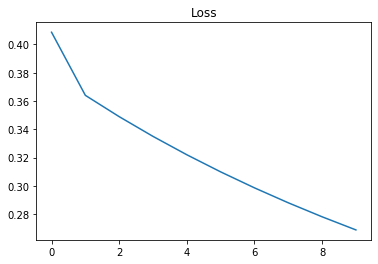

Got 60 / 60 correct 100.00%


In [7]:
model = LR(lr=1e-1, batchsize=64, epoch=10, shuffle=False, delta=1e-4)
model.train(x_train, y_train)
model.show_picture()
preds = model.pred(x_train)
check_accuracy(y_train, preds)

In [8]:
preds = model.pred(x_val)
check_accuracy(y_val, preds)

Got 20 / 20 correct 100.00%


In [9]:
preds = model.pred(x_test)
check_accuracy(y_test, preds)

Got 20 / 20 correct 100.00%


In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='none', multi_class='ovr')
clf.fit(x_train, y_train)
clf_preds = clf.predict(x_val)
check_accuracy(y_val, clf_preds)
clf_preds = clf.predict(x_test)
check_accuracy(y_test, clf_preds)

Got 20 / 20 correct 100.00%
Got 20 / 20 correct 100.00%
